In [60]:
from __future__ import division
import numpy as np
import nussl
import matplotlib.pyplot as plt
import erb as erb

In [74]:
# set parameters
window_length = 1024
hop_length = window_length // 2
window_type = 'hann'
n_fft_bins = window_length
B = 34
B2 = B+2
freqs_length = n_fft_bins // 2 + 1
sample_rate = 48000

Text(0,0.5,'Linear Amp [0-1]')

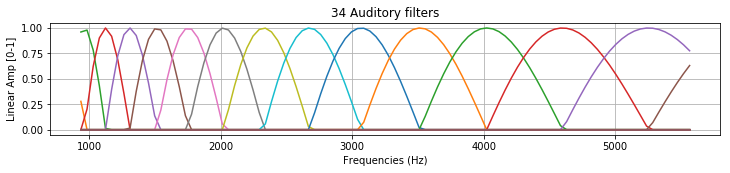

In [80]:
# Equivalent Rectangular Bandwidth
# Create an instance of the ERB filter bank class
erb_bank = erb.EquivalentRectangularBandwidth(freqs_length, sample_rate, B, 30, 22000)
freqs = erb_bank.freqs.tolist()
filters = erb_bank.filters
filters2 = np.power(filters, 2)

## Plot
plt.figure(figsize=(12,7))
plt.subplot(311)
plt.grid(True)
plt.plot(freqs[20:120],filters[20:120, :])
plt.title("%s Auditory filters"%B)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Linear Amp [0-1]')


In [73]:
print(erb_bank.freq_index)
print(erb_bank.bandwidths)
a = 'a' + '.b'
print(a)

[3, 4, 6, 9, 11, 14, 17, 21, 25, 30, 35, 41, 48, 56, 65, 75, 86, 99, 114, 131, 150, 172, 196, 224, 256, 292, 333, 380, 433, 493, 561, 638, 726, 826]
[74.999053139096, 85.1745765712468, 96.73066779438317, 109.85463583867104, 124.75920295412018, 141.6859525583007, 160.9092449856027, 182.74066450718027, 207.5340697019227, 235.69132903831655, 267.668834633437, 303.9848997685215, 345.22816006512494, 392.0671144938683, 445.2609608629566, 505.6719014155001, 574.2791179931642, 652.1946432851503, 740.6813854145903, 841.1735980171425, 955.3001276048599, 1084.910815024497, 1232.1064789430966, 1399.2729673537979, 1589.119829031868, 1804.7242317543796, 2049.580839140187, 2327.6584545479363, 2643.4643501552982, 3002.1173239091586, 3409.4306685036336, 3872.006397203959, 4397.342253792904, 4993.9532411299115]
a.b


(22L, 3L, 5L)


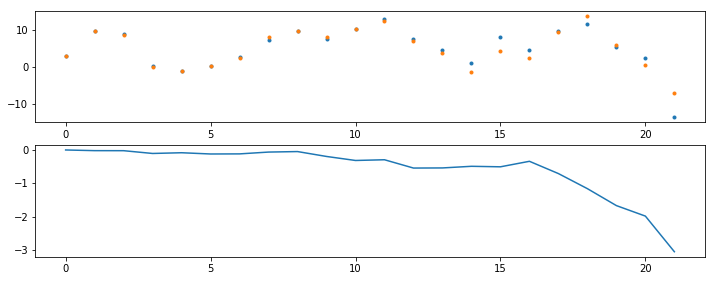

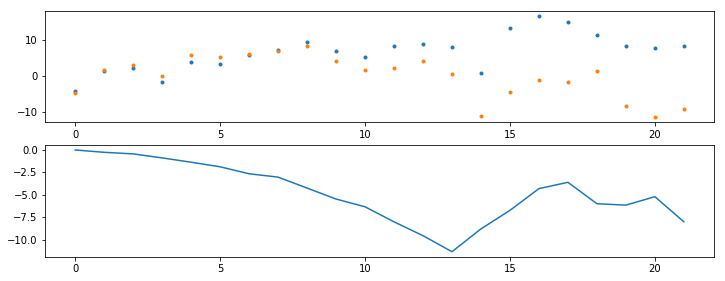

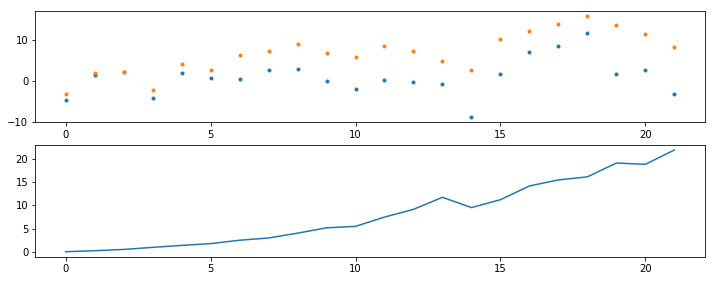

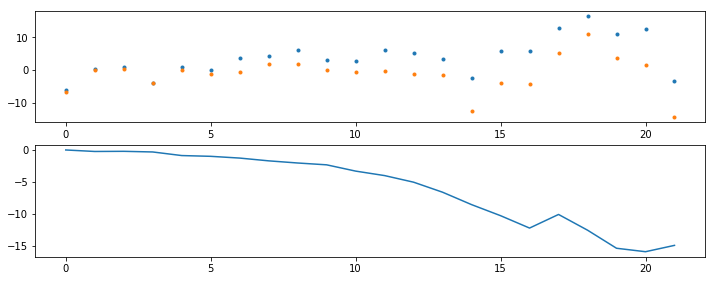

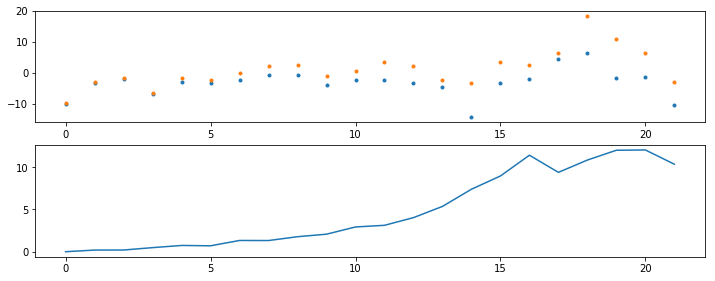

In [49]:
# preprocess BRIR 
brir_gain = 1
def brir_para(brir):
    K = brir.stft_data.shape[1] // 6 
    pFC = np.zeros((B2, 3))
    S = brir.stft_data

    for b in range(B2):
        corr = 0*1j
        for k in range(K):
            L = S[:, k, 0] * filters2[:, b]            
            R = S[:, k, 1] * filters2[:, b]                        
            
            pFC[b, 0] = pFC[b, 0] + np.real(np.vdot(L, L))
            pFC[b, 1] = pFC[b, 1] + np.real(np.vdot(R, R))
            corr = corr + np.vdot(L, R)

        pFC[b, 0] = pFC[b, 0] / K
        pFC[b, 1] = pFC[b, 1] / K
        pFC[b, 2] = np.angle(corr)
        
    pFC[:, 0] = np.sqrt(pFC[:, 0]) * brir_gain
    pFC[:, 1] = np.sqrt(pFC[:, 1]) * brir_gain
    pFC[:, 2] = np.unwrap(pFC[:, 2])
    return pFC

BRIRs = ['BRIR_FC_m.wav', 'BRIR_FL_m.wav', 'BRIR_FR_m.wav', 'BRIR_FLc_m.wav','BRIR_FRc_m.wav']
#BRIRs = ['IIS_BRIR_A+000_E+00.wav', 'IIS_BRIR_A+060_E+00.wav', 'IIS_BRIR_A-060_E+00.wav', 'IIS_BRIR_A+030_E+00.wav', 'IIS_BRIR_A-030_E+00.wav']
brir = np.zeros((B2, 3, 5))

i = 0
for brir_file in BRIRs:

    brir_sig = nussl.AudioSignal(brir_file)
    brir_sig.stft(window_length, hop_length, window_type, n_fft_bins)
    brir[:,:,i] = brir_para(brir_sig)
    i = i + 1

print(brir.shape)

if 1:
    for i in range(5):
        pFC = brir[:, :, i]
        plt.figure(figsize=(12,7))
        plt.subplot(311)
        plt.plot(20*np.log10(np.abs(pFC[:, 0:2])), '.')
        plt.subplot(312)
        plt.plot(pFC[:, 2])

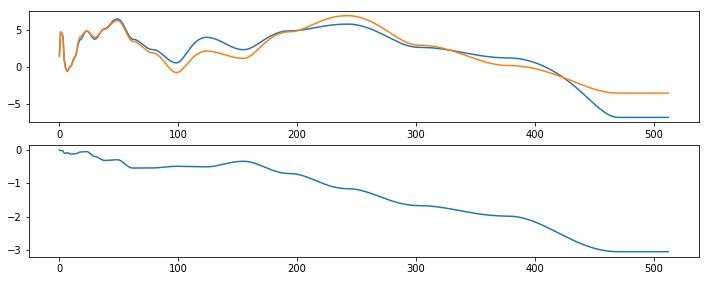

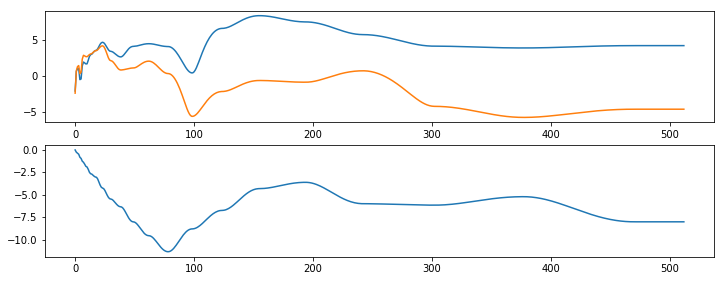

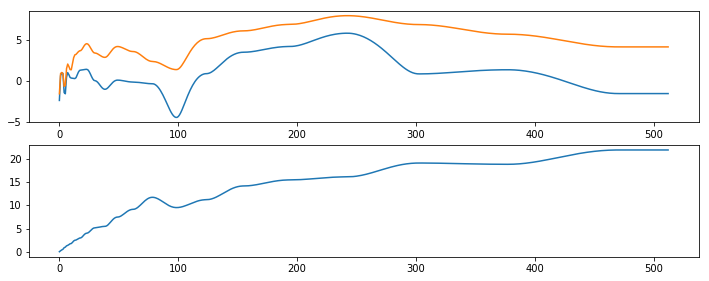

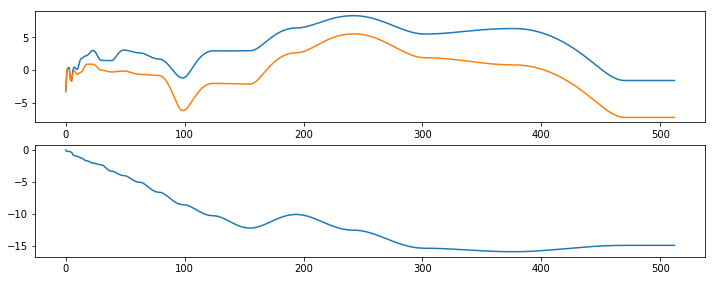

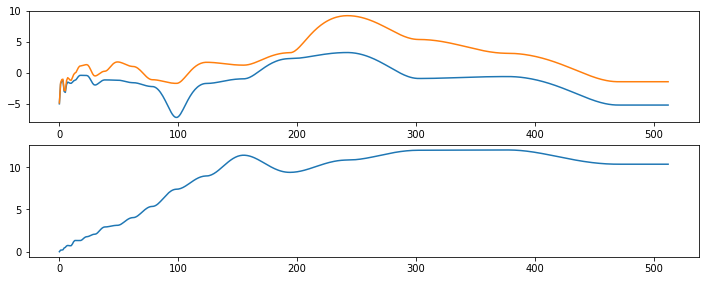

In [50]:
# generate brir filters
brir_filters = np.zeros((freqs_length, 3, 5))
for d in range(5):
    for t in range(3):
        for b in range(B2):
            brir_filters[:, t, d] = brir_filters[:, t, d] + filters2[:, b] * brir[b, t, d]

if 1:
    for i in range(5):
        pFC = brir_filters[:, :, i]
        plt.figure(figsize=(12,7))
        plt.subplot(311)
        plt.plot(10*np.log10(np.abs(pFC[:, 0:2])))            
        plt.subplot(312)
        plt.plot(pFC[:, 2])   

In [51]:
# load test file
file_path = 'test.wav'
sig = nussl.AudioSignal(file_path, sample_rate=sample_rate)
sig.stft(window_length, hop_length, window_type, n_fft_bins)
#sig.plot_spectrogram()
print(sig.sample_rate)
print(sig.stft_data.shape)
M = sig.stft_data.shape[1]

# get subband analysis of source
S = sig.stft_data
BS = np.zeros((S.shape[0], B2, S.shape[1], S.shape[2]), dtype=np.complex_)
for m in range(M):
    for b in range(B2):
        BS[:, b, m, 0] = S[:, m, 0] * filters[:, b]
        BS[:, b, m, 1] = S[:, m, 1] * filters[:, b]
        
print(BS.shape, filters.shape)

48000
(513L, 2302L, 2L)
((513L, 22L, 2302L, 2L), (513L, 22L))


In [52]:
# 经测试， S，D的提取出问题了，出现了不连续，或者是误差大的情况
# Binaural rendering by J. Breebaart

a_BS = np.zeros((B2, M, 2))
v_BS = np.zeros((B2, M))
b_BS = np.zeros((B2, M))
g_BS = np.zeros((B2, M))
SD_BS = np.zeros(BS.shape, dtype=np.complex_)

time_lf_sm = 0.0
time_hf_sm = 0.0
lhf = 10
freq_sm = 0.0


# spatial analysis
for m in range(M):
    for b in range(B2):
        L = BS[:, b, m, 0]
        R = BS[:, b, m, 1]
        a_BS[b, m, 0] = np.sqrt(np.real(np.vdot(L, L)))
        a_BS[b, m, 1] = np.sqrt(np.real(np.vdot(R, R)))
        v_BS[b, m] = 0.5 * np.arccos(np.real(np.vdot(L, R)) / (a_BS[b, m, 0] * a_BS[b, m, 1]))
        b_BS[b, m] = np.tan(((a_BS[b, m, 1] - a_BS[b, m, 0])/(a_BS[b, m, 1] + a_BS[b, m, 0]))*np.arctan(v_BS[b,m]))
        g_BS[b, m] = np.arctan((a_BS[b, m, 0]*np.cos(v_BS[b, m]+b_BS[b, m]))/(a_BS[b, m, 1]*np.cos(-v_BS[b, m]+b_BS[b, m])))
        
        # angle smoothing
        if m > 0:        
            if b < lhf:
                g_BS[b, m] = time_lf_sm * g_BS[b, m-1] + (1 - time_lf_sm) * g_BS[b, m]
            else:
                g_BS[b, m] = time_hf_sm * g_BS[b, m-1] + (1 - time_hf_sm) * g_BS[b, m]
                
        if b > 0:
            g_BS[b, m] = freq_sm * g_BS[b - 1, m] + (1 - freq_sm) * g_BS[b, m]
        
        
        
        SD_BS[:, b, m, 0] = (L + R) / (np.sin(g_BS[b, m]) + np.cos(g_BS[b, m]))
        SD_BS[:, b, m, 1] = L - np.sin(g_BS[b, m]) * SD_BS[:, b, m, 0]
        #SD_BS[:, b, m, 0] = L+R
        #SD_BS[:, b, m, 1] = L-R

0.7071067811865475


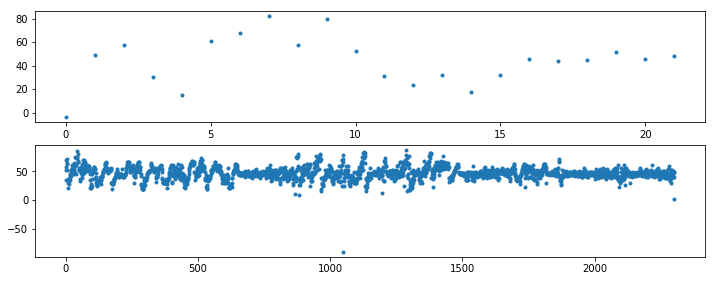

In [41]:
plt.figure(figsize=(12,7))
plt.subplot(311)
plt.plot(g_BS[:, 64] * 180.0 / np.pi, '.')
plt.subplot(312)
plt.plot(g_BS[10, :] * 180.0 / np.pi, '.')

print(np.sin(np.pi/4))

In [53]:
# angle compute
ang_BS = np.abs(g_BS * 180.0 / np.pi)
ang_BS = 60 - ang_BS * (120.0) / 90.0
print(np.max(ang_BS[:, :]))
print(np.min(ang_BS[:, :]))

59.9958810191011
-59.995372232914434


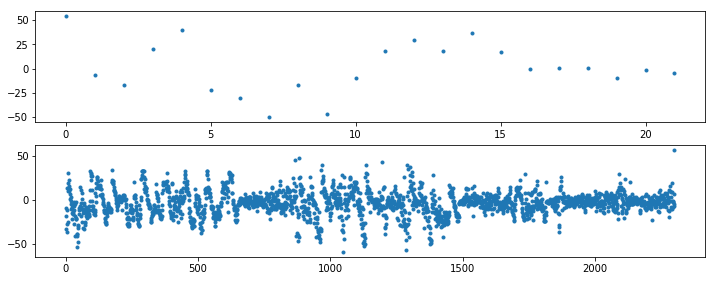

In [43]:
plt.figure(figsize=(12,7))
plt.subplot(311)
plt.plot(ang_BS[:, 64], '.')
plt.subplot(312)
plt.plot(ang_BS[10, :], '.')

In [55]:
# spatial synthesis
(FC, FL, FR, FLc, FRc) = [0, 1, 2, 3, 4]
Y_out = np.zeros(sig.stft_data.shape, dtype=np.complex_)

for m in range(M):
    #Y_out[:, m, 0] = Y_out[:, m, 0] + SD_BS[:, 0, m, 0] * filters[:, 0]
    #Y_out[:, m, 1] = Y_out[:, m, 1] + SD_BS[:, 0, m, 1] * filters[:, 0]
    #Y_out[:, m, 0] = Y_out[:, m, 0] + SD_BS[:, B+1, m, 0] * filters[:, B+1]
    #Y_out[:, m, 1] = Y_out[:, m, 1] + SD_BS[:, B+1, m, 0] * filters[:, B+1]     
    for b in range(B2):        
    
        if ang_BS[b, m] < -30:
            S_brir = FL
        elif ang_BS[b, m] < -10:
            S_brir = FLc
        elif ang_BS[b, m] < 10:
            S_brir = FC
        elif ang_BS[b, m] < 30:
            S_brir = FRc
        else:
            S_brir = FR      
        
        S = SD_BS[:, b, m, 0] * filters[:, b]
        D = SD_BS[:, b, m, 1] * filters[:, b]

        if 0:
            if 1:
                Y_out[:, m, 0] = Y_out[:, m, 0] + S * brir[b, 0, S_brir] * np.exp(-1j * brir[b, 2, S_brir] * 0.5)
                Y_out[:, m, 0] = Y_out[:, m, 0] + D * brir[b, 0, FL] * np.exp(-1j * brir[b, 2, FL] * 0.5)
                Y_out[:, m, 0] = Y_out[:, m, 0] - D * brir[b, 0, FR] * np.exp(-1j * brir[b, 2, FR] * 0.5)

                Y_out[:, m, 1] = Y_out[:, m, 1] + S * brir[b, 1, S_brir] * np.exp(1j * brir[b, 2, S_brir] * 0.5)
                Y_out[:, m, 1] = Y_out[:, m, 1] + D * brir[b, 1, FL] * np.exp(1j * brir[b, 2, FL] * 0.5)
                Y_out[:, m, 1] = Y_out[:, m, 1] - D * brir[b, 1, FR] * np.exp(1j * brir[b, 2, FR] * 0.5)
            else:
                Y_out[:, m, 0] = Y_out[:, m, 0] + S * brir_filters[:, 0, S_brir] * np.exp(-1j * brir_filters[:, 2, S_brir] * 0.5)
                Y_out[:, m, 0] = Y_out[:, m, 0] + D * brir_filters[:, 0, FL] * np.exp(-1j * brir_filters[:, 2, FL] * 0.5)
                Y_out[:, m, 0] = Y_out[:, m, 0] - D * brir_filters[:, 0, FR] * np.exp(-1j * brir_filters[:, 2, FR] * 0.5)

                Y_out[:, m, 1] = Y_out[:, m, 1] + S * brir_filters[:, 1, S_brir] * np.exp(1j * brir_filters[:, 2, S_brir] * 0.5)
                Y_out[:, m, 1] = Y_out[:, m, 1] + D * brir_filters[:, 1, FL] * np.exp(1j * brir_filters[:, 2, FL] * 0.5)
                Y_out[:, m, 1] = Y_out[:, m, 1] - D * brir_filters[:, 1, FR] * np.exp(1j * brir_filters[:, 2, FR] * 0.5)
            
            
        else:
            Y_out[:, m, 0] = Y_out[:, m, 0] + S
            Y_out[:, m, 1] = Y_out[:, m, 1] + D


#Y_out = Y_out

sig_direct = nussl.AudioSignal(stft=Y_out, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('test_JB0320h4.wav') 

In [ ]:
# spatial synthesis
(FC, FL, FR, FLc, FRc) = [0, 1, 2, 3, 4]
Y_out = np.zeros(sig.stft_data.shape, dtype=np.complex_)
#pre_ang = np.zeros(B)
#sm_ang = 0.6
for m in range(M):
    #Y_out[:, m, 0] = Y_out[:, m, 0] + BS[:, 0, m, 0] * filters[:, 0]
    #Y_out[:, m, 1] = Y_out[:, m, 1] + BS[:, 0, m, 1] * filters[:, 0]
    #Y_out[:, m, 0] = Y_out[:, m, 0] + BS[:, B+1, m, 0] * filters[:, B+1]
    #Y_out[:, m, 1] = Y_out[:, m, 1] + BS[:, B+1, m, 1] * filters[:, B+1]    
    for b in range(B2):        
 #       ang_BS[b, m] = sm_ang * pre_ang[b] + (1 - sm_ang) * ang_BS[b, m]
    
        if ang_BS[b, m] < -30:
            S_brir = FL
        elif ang_BS[b, m] < -10:
            S_brir = FLc
        elif ang_BS[b, m] < 10:
            S_brir = FC
        elif ang_BS[b, m] < 30:
            S_brir = FRc
        else:
            S_brir = FR
        
        #pre_ang[b] = ang_BS[b, m]
        
        S = SD_BS[:, b, m, 0] * filters[:, b]
        D = SD_BS[:, b, m, 1] * filters[:, b]
        #S = BS[:, b, m, 0] * filters[:, b]
        #D = BS[:, b, m, 1] * filters[:, b]

        if 1:
            #Y_out[:, m, 0] = Y_out[:, m, 0] + S * brir[b, 0, S_brir] * np.exp(-1j * brir[b, 2, S_brir] * 0.5)
            Y_out[:, m, 0] = Y_out[:, m, 0] + D * brir[b, 0, FL] * np.exp(-1j * brir[b, 2, FL] * 0.5)
            Y_out[:, m, 0] = Y_out[:, m, 0] - D * brir[b, 0, FR] * np.exp(-1j * brir[b, 2, FR] * 0.5)

            #Y_out[:, m, 1] = Y_out[:, m, 1] + S * brir[b, 1, S_brir] * np.exp(1j * brir[b, 2, S_brir] * 0.5)
            Y_out[:, m, 1] = Y_out[:, m, 1] + D * brir[b, 1, FL] * np.exp(1j * brir[b, 2, FL] * 0.5)
            Y_out[:, m, 1] = Y_out[:, m, 1] - D * brir[b, 1, FR] * np.exp(1j * brir[b, 2, FR] * 0.5)
        else:
            Y_out[:, m, 0] = Y_out[:, m, 0] + S
            Y_out[:, m, 1] = Y_out[:, m, 1] + D


#Y_out = Y_out

sig_direct = nussl.AudioSignal(stft=Y_out, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('djdh_JB0320f.wav') 

In [ ]:
print(Y_out.shape)

In [ ]:
# 测试结果表明，ERB filters本身没有问题，
# 完全重构需要加上第一个band和最后一个band
# 第一个最重要
# np.sum(np.power(filters,1)) 可以得到全一序列

# test filters 合成
plt.figure(figsize=(12,7))
plt.subplot(311)
plt.grid(True)
plt.plot(filters[0:20, 0:4], '.')
plt.title("%s Auditory filters"%B)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Linear Amp [0-1]')

m_filters = np.power(filters, 2)
print(m_filters.shape)
sum_filters = np.sum(m_filters, 1)
print(sum_filters.shape)
plt.subplot(312)
plt.grid(True)
plt.plot(sum_filters, '.')

# test ERB analysis and synthesis
# set parameters
window_length = 1024
hop_length = 512
window_type = 'hann'
n_fft_bins = 1024
B = 20
freqs_length = n_fft_bins // 2 + 1
sample_rate = 48000

# load test file
file_path = 'djdh.wav'
sig = nussl.AudioSignal(file_path, sample_rate=sample_rate)
sig.stft(window_length, hop_length, window_type, n_fft_bins)
#sig.plot_spectrogram()
print(sig.sample_rate)
print(sig.stft_data.shape)
M = sig.stft_data.shape[1]

S = sig.stft_data

# get subband analysis of source
p_filters = np.power(filters, 2)
BS = np.zeros((S.shape[0], B+2, S.shape[1], S.shape[2]), dtype=np.complex_)
for m in range(M):
    for b in range(0,B+1):
        BS[:, b, m, 0] = S[:, m, 0] * filters[:, b]
        BS[:, b, m, 1] = S[:, m, 1] * filters[:, b]
        
Y_out = np.zeros(sig.stft_data.shape, dtype=np.complex_)
for m in range(M):
    for b in range(0,B+1):
        L = BS[:, b, m, 0] * filters[:, b]
        R = BS[:, b, m, 1] * filters[:, b]
        Y_out[:, m, 0] = Y_out[:, m, 0] + L
        Y_out[:, m, 1] = Y_out[:, m, 1] + R
        
# output file
sig_direct = nussl.AudioSignal(stft=Y_out, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('test_JB0320e.wav') 

print('process end')

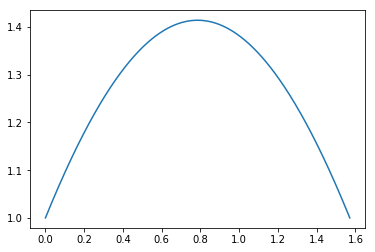

In [58]:
x = np.linspace(0, np.pi/2.0, 1000)
y = np.sin(x) + np.cos(x)

plt.plot(x, y)